In [13]:
import os
import torch
import numpy as np
import cv2
import matplotlib.pyplot as plt
from torchvision import transforms

# Load your model definition
from model import Attention_UNET

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)


Using device: cuda


In [ ]:
#This is the code to train the model on the dataset. To train the model, uncomment and run this section first, and the model weights will be saved.
#Rerun the rest of the notebook after training.

# # Imports
# import os
# import torch
# from torch import nn
# from torch.utils.data import Dataset, DataLoader
# from torchvision import transforms
# from PIL import Image
# from tqdm import tqdm
# import numpy as np
# import matplotlib.pyplot as plt

# # Device
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# print("Using device:", device)

# # Dataset class
# class CarvanaDataset(Dataset):
#     def __init__(self, img_dir, mask_dir, transform=None):
#         self.img_dir = img_dir
#         self.mask_dir = mask_dir
#         self.transform = transform
#         self.img_names = [f for f in os.listdir(img_dir) if f.endswith(".jpg")]

#     def __len__(self):
#         return len(self.img_names)

#     def __getitem__(self, idx):
#         img_name = self.img_names[idx]
#         img_path = os.path.join(self.img_dir, img_name)
#         mask_path = os.path.join(self.mask_dir, img_name.replace(".jpg", "_mask.gif"))

#         image = Image.open(img_path).convert("RGB")
#         mask = Image.open(mask_path).convert("L")

#         if self.transform:
#             image = self.transform(image)
#             mask = self.transform(mask)

#         mask = (mask > 0.5).float()
#         return image, mask

# # Transforms
# IMG_SIZE = (256, 256)
# transform = transforms.Compose([
#     transforms.Resize(IMG_SIZE),
#     transforms.ToTensor(),
# ])

# # DataLoader
# train_dataset = CarvanaDataset(
#     img_dir=r"C:\Users\ved\Desktop\MyProjects\Carvana\train\train",
#     mask_dir=r"C:\Users\ved\Desktop\MyProjects\Carvana\train_masks\train_masks",
#     transform=transform
# )
# train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True)

# # Import your model class
# from model import Attention_UNET

# # Initialize model
# model = Attention_UNET(in_channels=3, out_channels=1).to(device)

# # Loss and optimizer
# criterion = nn.BCEWithLogitsLoss()
# optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

# # Metrics
# def iou(pred, target, threshold=0.5):
#     pred = (torch.sigmoid(pred) > threshold).byte()
#     target = target.byte()
#     intersection = (pred & target).float().sum((1, 2, 3))
#     union = (pred | target).float().sum((1, 2, 3))
#     iou_score = (intersection / (union + 1e-6)).mean().item()
#     return iou_score

# def dice(pred, target, threshold=0.5, eps=1e-6):
#     pred = (torch.sigmoid(pred) > threshold).float()
#     target = target.float()
#     intersection = (pred * target).sum(dim=(1, 2, 3))
#     dice_score = (2 * intersection / (pred.sum(dim=(1, 2, 3)) + target.sum(dim=(1, 2, 3)) + eps)).mean().item()
#     return dice_score

# # Training loop
# def train_model(model, loader, criterion, optimizer, device, epochs=10):
#     model.train()
#     for epoch in range(epochs):
#         loop = tqdm(loader, desc=f"Epoch {epoch+1}/{epochs}")
#         epoch_loss = 0
#         epoch_iou = 0
#         epoch_dice = 0
        
#         for images, masks in loop:
#             images = images.to(device)
#             masks = masks.to(device)

#             preds = model(images)
#             loss = criterion(preds, masks)

#             optimizer.zero_grad()
#             loss.backward()
#             optimizer.step()

#             epoch_loss += loss.item()
#             epoch_iou += iou(preds, masks)
#             epoch_dice += dice(preds, masks)

#             loop.set_postfix(loss=loss.item(), iou=epoch_iou/(loop.n+1), dice=epoch_dice/(loop.n+1))

#         print(f"Epoch {epoch+1} - Loss: {epoch_loss/len(loader):.4f}, IoU: {epoch_iou/len(loader):.4f}, Dice: {epoch_dice/len(loader):.4f}")

# # Run training
# train_model(model, train_loader, criterion, optimizer, device, epochs=10)

# # Save the trained model
# torch.save(model.state_dict(), "attention_unet_carvana.pth")
# print("Model saved!")


In [14]:
# Initialize and load weights
model = Attention_UNET(in_channels=3, out_channels=1).to(device)
model.load_state_dict(torch.load("attention_unet_carvana.pth", map_location=device))
model.eval()


Attention_UNET(
  (ups): ModuleList(
    (0): ConvTranspose2d(1024, 512, kernel_size=(2, 2), stride=(2, 2))
    (1): DoubleConv(
      (conv): Sequential(
        (0): Conv2d(1024, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU(inplace=True)
        (3): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (4): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (5): ReLU(inplace=True)
      )
    )
    (2): AttentionGate(
      (W_g): Sequential(
        (0): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
        (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (W_x): Sequential(
        (0): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
        (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stat

In [15]:
IMG_DIR = r"C:/Users/ved/Desktop/MyProjects/Carvana/train/train"
MASK_DIR = r"C:/Users/ved/Desktop/MyProjects/Carvana/train_masks/train_masks"
IMG_SIZE = (161, 161)

from PIL import Image

def load_image_mask(img_name):
    img_path = os.path.join(IMG_DIR, img_name)
    mask_name = img_name.replace(".jpg", "_mask.gif")
    mask_path = os.path.join(MASK_DIR, mask_name)

    print(f"Image path: {img_path}")
    print(f"Mask path: {mask_path}")

    if not os.path.exists(img_path):
        raise FileNotFoundError(f"Image not found: {img_path}")
    if not os.path.exists(mask_path):
        raise FileNotFoundError(f"Mask not found: {mask_path}")

    # Load and preprocess image
    image = cv2.imread(img_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = cv2.resize(image, IMG_SIZE)
    image = image / 255.0
    image = np.transpose(image, (2, 0, 1))
    image_tensor = torch.tensor(image, dtype=torch.float32).unsqueeze(0).to(device)

    # Load and preprocess mask using PIL
    mask = Image.open(mask_path).convert("L")  # grayscale
    mask = mask.resize(IMG_SIZE)
    mask = np.array(mask) / 255.0
    mask_tensor = torch.tensor(mask, dtype=torch.float32).unsqueeze(0).unsqueeze(0)

    return image_tensor, mask_tensor

Image path: C:/Users/ved/Desktop/MyProjects/Carvana/train/train\0cdf5b5d0ce1_01.jpg
Mask path: C:/Users/ved/Desktop/MyProjects/Carvana/train_masks/train_masks\0cdf5b5d0ce1_01_mask.gif


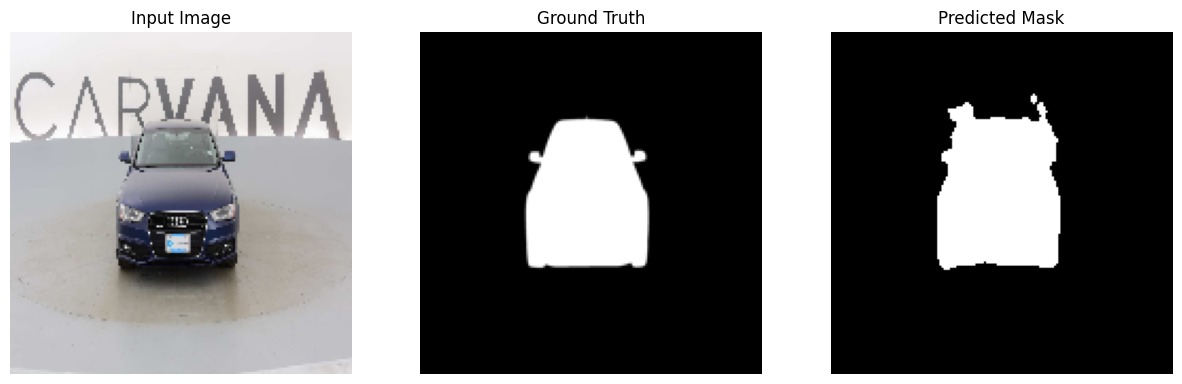

In [16]:
def show_results(img_tensor, gt_mask, pred_mask):
    img = img_tensor.squeeze().cpu().numpy().transpose(1, 2, 0)
    gt = gt_mask.squeeze().numpy()
    pred = pred_mask.squeeze().cpu().numpy()

    fig, ax = plt.subplots(1, 3, figsize=(15, 5))
    ax[0].imshow(img)
    ax[0].set_title("Input Image")
    ax[1].imshow(gt, cmap="gray")
    ax[1].set_title("Ground Truth")
    ax[2].imshow(pred, cmap="gray")
    ax[2].set_title("Predicted Mask")
    for a in ax:
        a.axis("off")
    plt.show()

# Example test
img_name = "0cdf5b5d0ce1_01.jpg"
img_tensor, gt_mask = load_image_mask(img_name)

with torch.no_grad():
    pred = model(img_tensor)
    pred = torch.sigmoid(pred)
    pred_mask = (pred > 0.5).float()

show_results(img_tensor, gt_mask, pred_mask)


In [17]:
def iou(pred, target, threshold=0.5, eps=1e-6):
    pred = (torch.sigmoid(pred) > threshold).byte()  # Apply sigmoid and threshold before binarizing
    target = target.byte()
    intersection = (pred & target).float().sum((1, 2, 3))  # Adjust dims if needed
    union = (pred | target).float().sum((1, 2, 3))
    iou_score = (intersection / (union + eps)).mean().item()  # Avoid division by zero
    return iou_score

def dice(pred, target, eps=1e-6):
    pred = pred.view(-1)
    target = target.view(-1)
    intersection = (pred * target).sum()
    return (2. * intersection / (pred.sum() + target.sum() + eps)).item()

print("IoU:", iou(pred_mask.cpu(), gt_mask))
print("Dice Score:", dice(pred_mask.cpu(), gt_mask))


IoU: 0.8560250401496887
Dice Score: 0.940555989742279
